# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory

In [1]:
!mkdir -p ./kaggle
!cp /content/kaggle.json ~/.kaggle/

cp: cannot stat '/content/kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 99% 60.0M/60.3M [00:03<00:00, 23.1MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.4MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [4]:
!pip install TensorFlow Keras

# Installing Packages

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [6]:
os.makedirs('test_dir', exist_ok=True)

In [7]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning

In [8]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

In [9]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


        sad  angry  surprise  happy  disgust  neutral  fear
train  4830   3995      3171   7215      436     4965  4097
       sad  angry  surprise  happy  disgust  neutral  fear
test  1247    958       831   1774      111     1233  1024


<Axes: >

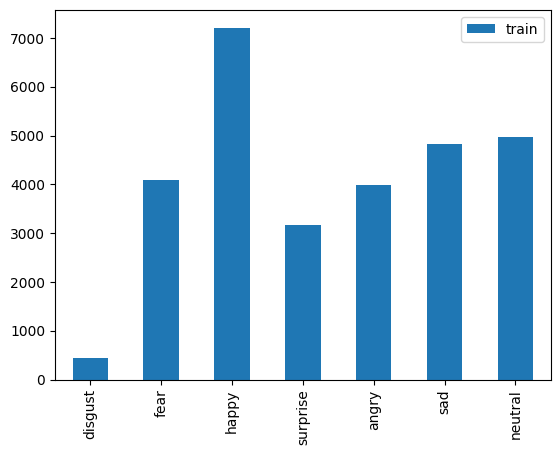

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

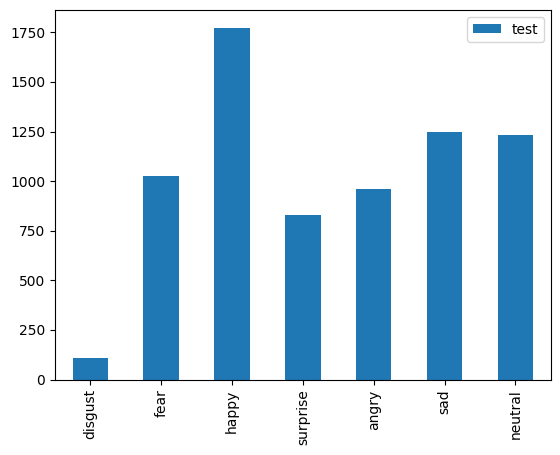

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

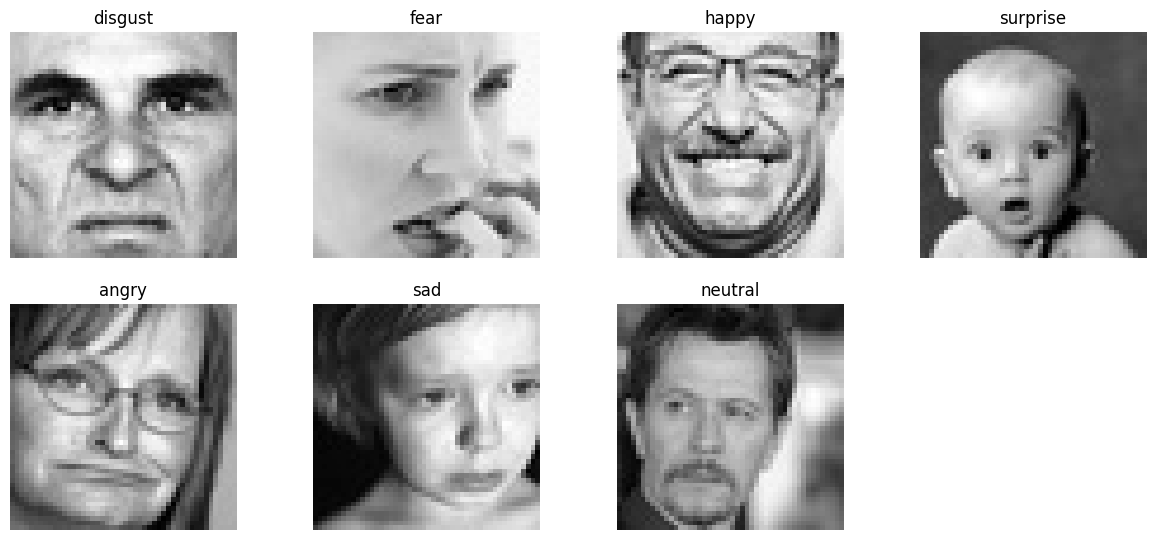

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

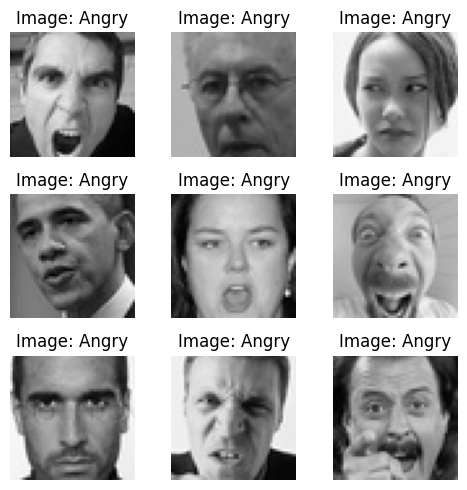

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

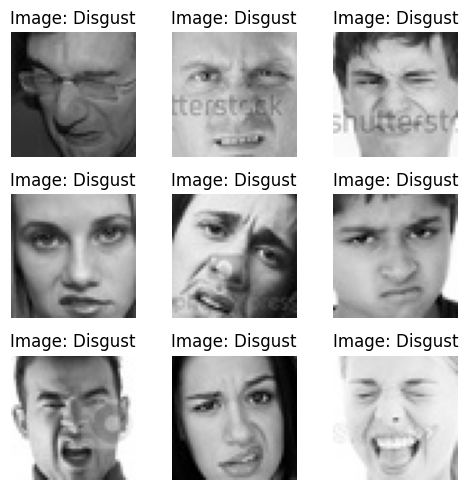

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

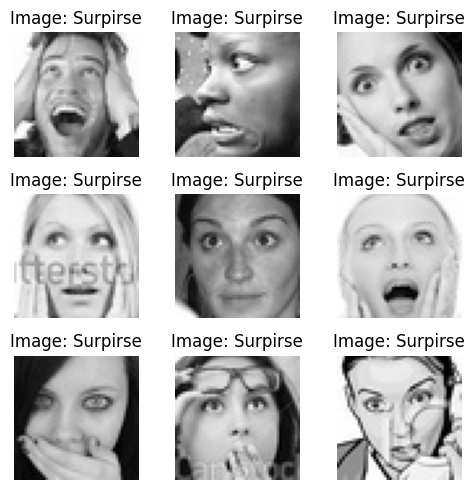

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

In [ ]:
# Define image dimensions and batch size
img_width, img_height = 48, 48
batch_size = 64
num_classes = 7

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Set validation split
)

# Only rescaling for test
test_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Use same directory
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/sample_data/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [ ]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - accuracy: 0.2389 - loss: 13.3938 - val_accuracy: 0.1736 - val_loss: 15.5610
Epoch 2/20
  1/358 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.3750 - loss: 11.1113

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3750 - loss: 11.1113 - val_accuracy: 0.0889 - val_loss: 16.4511
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.3361 - loss: 10.6800 - val_accuracy: 0.3857 - val_loss: 9.3451
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.2969 - loss: 9.1442 - val_accuracy: 0.3778 - val_loss: 9.4686
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.3825 - loss: 8.6263 - val_accuracy: 0.4249 - val_loss: 7.3306
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5156 - loss: 7.1550 - val_accuracy: 0.5111 - val_loss: 7.0678
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.4305 - loss: 6.8178 - val_accuracy: 0.4473 - val_loss: 5.7904
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4531 - loss: 5.7492 - val_accuracy: 0.4444 - val_loss: 5.5895
Epoch 9/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.4633 - loss: 5.3598 - val_accuracy:

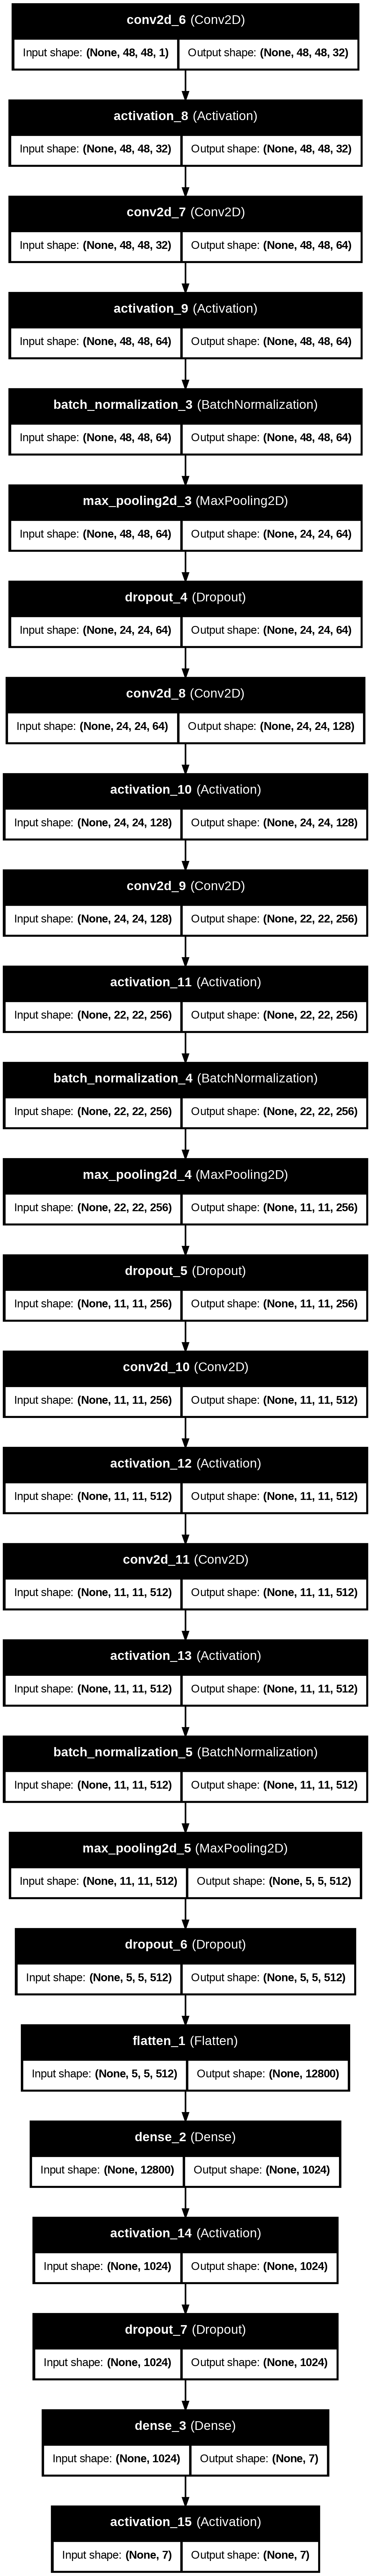

In [ ]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Plotting Performance Metrics

In [1]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

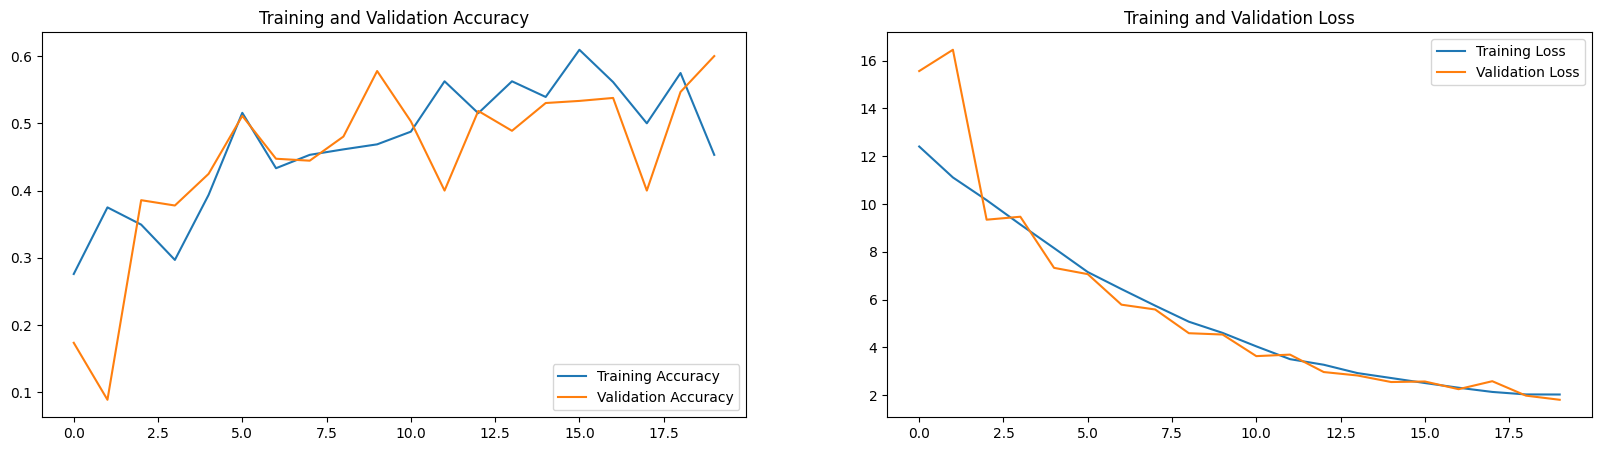

In [ ]:
plot_training_history(history)

# Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6307 - loss: 1.8138
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4778 - loss: 2.1567
final train accuracy = 63.45 , validation accuracy = 54.93


# Plotting Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


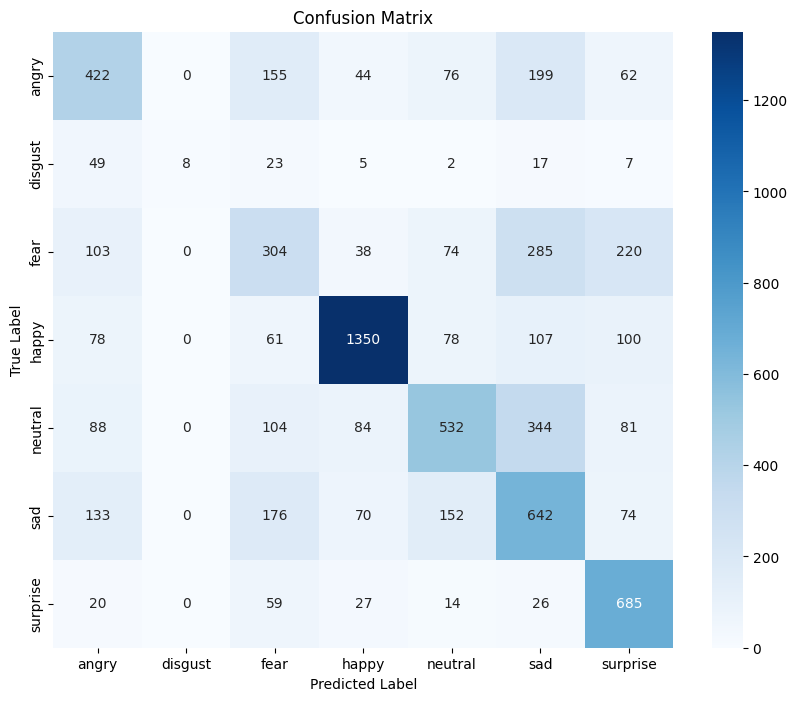

In [ ]:
# Make predictions on the test set
true_classes = test_generator.classes
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define the class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.44      0.46       958
     disgust       1.00      0.07      0.13       111
        fear       0.34      0.30      0.32      1024
       happy       0.83      0.76      0.80      1774
     neutral       0.57      0.43      0.49      1233
         sad       0.40      0.51      0.45      1247
    surprise       0.56      0.82      0.67       831

    accuracy                           0.55      7178
   macro avg       0.60      0.48      0.47      7178
weighted avg       0.57      0.55      0.54      7178



# Making Predictions

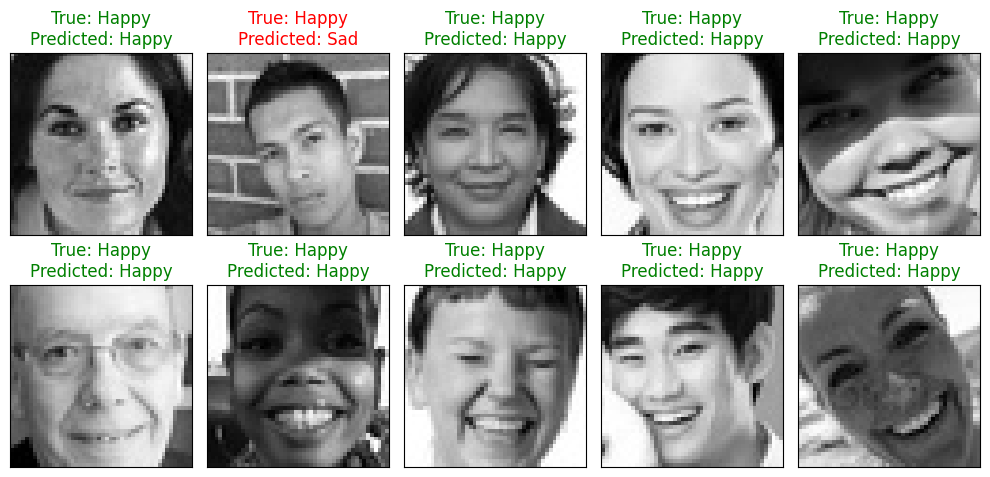

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'


# Define image dimensions and batch size
img_width, img_height = 48, 48
batch_size = 64
num_classes = 7

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set validation split
)

# Only rescaling for test
test_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,  # Use same directory
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


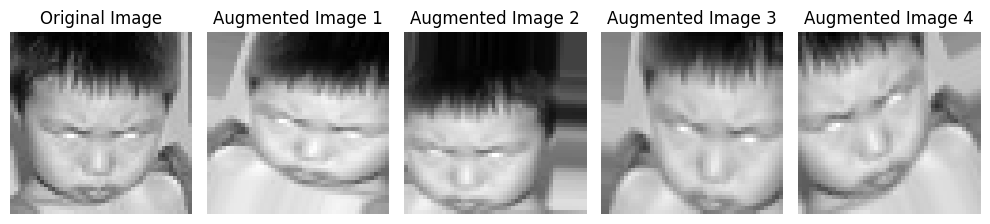

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/sample_data/best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [model_checkpoint, early_stopping, csv_logger]  # Adjusted as per your use-case

# train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
# test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 63s 154ms/step - accuracy: 0.2083 - loss: 13.5046 - val_accuracy: 0.1750 - val_loss: 12.9369
Epoch 2/20
  1/358 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.1562 - loss: 11.4077

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1562 - loss: 11.4077 - val_accuracy: 0.1556 - val_loss: 14.4317
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.2391 - loss: 10.8141 - val_accuracy: 0.2575 - val_loss: 10.4488
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.2188 - loss: 9.1985 - val_accuracy: 0.1778 - val_loss: 10.9274
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.2428 - loss: 8.6751 - val_accuracy: 0.2623 - val_loss: 7.2947
Epoch 6/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2344 - loss: 7.1658 - val_accuracy: 0.2444 - val_loss: 7.3716
Epoch 7/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.2515 - loss: 6.7652 - val_accuracy: 0.2637 - val_loss: 6.6181
Epoch 8/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.2969 - loss: 5.5370 - val_accuracy: 0.2667 - val_loss: 7.6703
Epoch 9/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.2595 - loss: 5.2421 - val_accura

In [ ]:
# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.4344 - loss: 1.8167 - val_accuracy: 0.4624 - val_loss: 1.6814
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3929 - loss: 1.7953 - val_accuracy: 0.4889 - val_loss: 1.8608
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.4686 - loss: 1.6962 - val_accuracy: 0.4661 - val_loss: 1.6384
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4062 - loss: 1.7769 - val_accuracy: 0.4667 - val_loss: 1.6359
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.4747 - loss: 1.6260 - val_accuracy: 0.4837 - val_loss: 1.5803
Epoch 6/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5156 - loss: 1.5459 - val_accuracy: 0.4667 - val_loss: 1.7072
Epoch 7/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.4897 - loss: 1.5724 - val_accuracy: 0.5054 - val_loss: 1.5241
Epoch 8/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.4531 - loss: 1.558

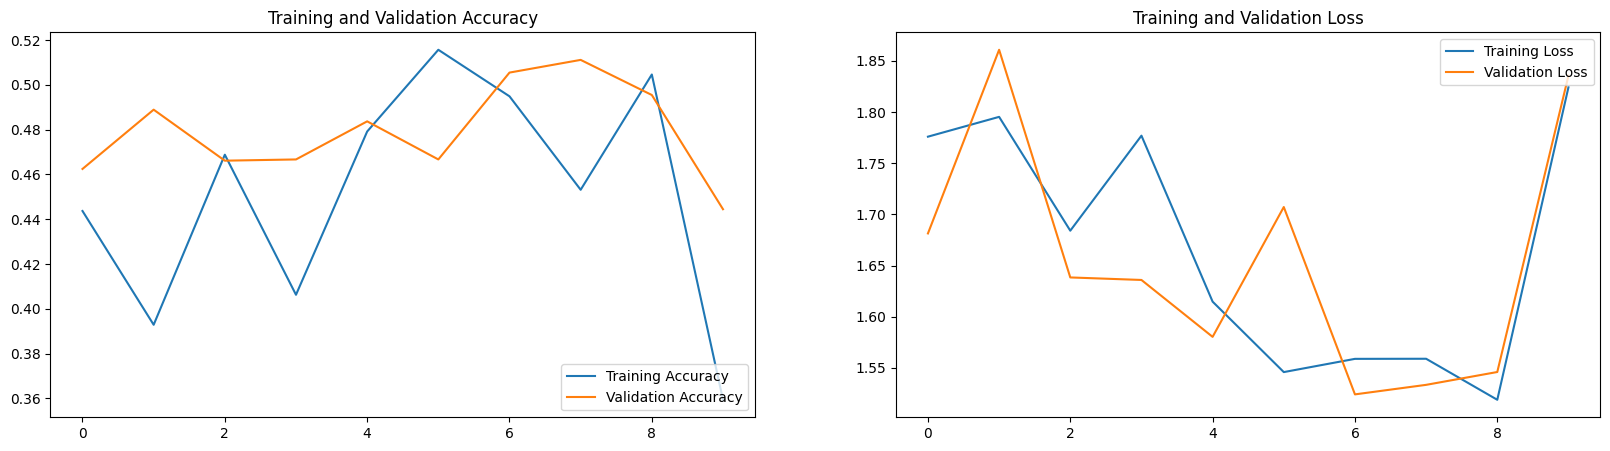

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - accuracy: 0.5182 - loss: 1.4880
  7/113 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4888 - loss: 1.5383

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4566 - loss: 1.5937
final train accuracy = 51.70 , validation accuracy = 53.40


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


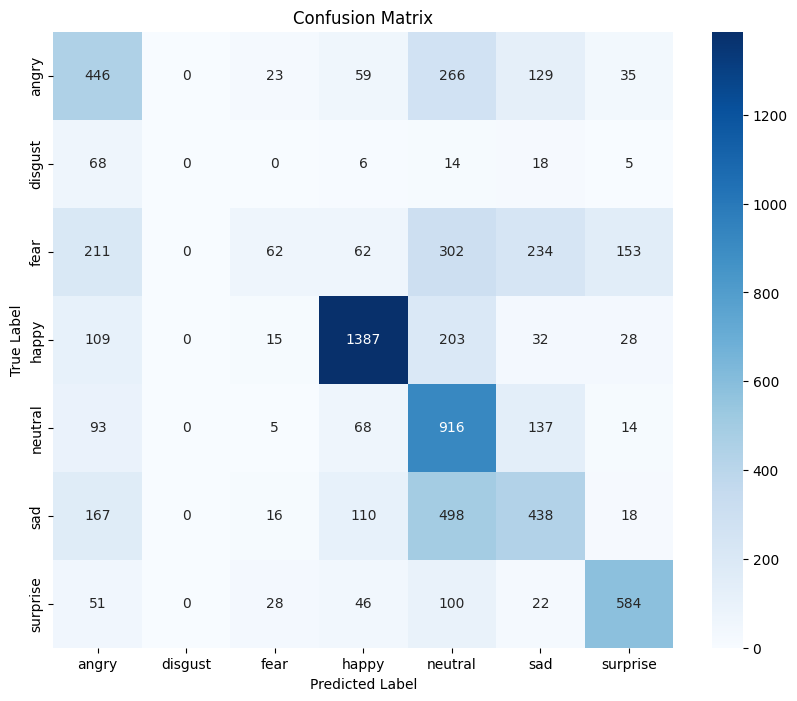

In [ ]:
# Make predictions on the test set
true_classes = test_generator.classes
y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define the class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               y_pred_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.39      0.47      0.42       958
     disgust       0.00      0.00      0.00       111
        fear       0.42      0.06      0.11      1024
       happy       0.80      0.78      0.79      1774
     neutral       0.40      0.74      0.52      1233
         sad       0.43      0.35      0.39      1247
    surprise       0.70      0.70      0.70       831

    accuracy                           0.53      7178
   macro avg       0.45      0.44      0.42      7178
weighted avg       0.53      0.53      0.50      7178

